In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score, roc_curve, auc    
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE

import itertools as itt
from typing import Union

# Configuración de estilo para las gráficas
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [2]:
# Se carga el dataset reducido dimensionalmente en un dataframe
df_model = pd.read_csv('./data/creditcard_model.csv', sep=',', engine='python')

# Se separan las variables independientes de la variable objetivo
X = df_model.drop('Class', axis=1)
y = df_model['Class']

# Se divide el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Se escalan las variables independientes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Se crea un dataframe de entrenamiento con las variables predictoras correspondientes a transacciones legítimas
X_train_normal = X_train_scaled[y_train == 0]

In [3]:
# Se declara una función para graficar y calular la métrica AUC-ROC
def metrica_roc_auc(n_modelo, y_prueba, proba_predicciones):
    """
    Grafica ROC y calcula AUC como medidas de desempeño del clasificador.
    
    Args:
    n_modelo (str): Nombre del modelo de clasificación.
    y_prueba (array-like): Etiquetas verdaderas de la muestra de prueba.
    proba_predicciones (array-like): Matriz de probabilidades predichas.
    
    Returns:
    float: El valor AUC-ROC calculado.
    """
    fpr, tpr, _ = roc_curve(y_prueba, -proba_predicciones)
    auc_roc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC - Direction (AUC = {auc_roc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {n_modelo}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    return print(f"AUC - ROC para {n_modelo} es: {auc_roc:.5f}")

# Se declara una función para graficar la matriz de confusión
def matriz_confusion(y_prueba: Union[list, np.ndarray], 
                     predicciones: Union[list, np.ndarray],
                     class_labels: list = ['0', '1']) -> None:
    """
    Muestra la matriz de confusión en un formato visual.

    Args:
    y_prueba (Union[list, np.ndarray]): Etiquetas verdaderas de la muestra de prueba.
    predicciones (Union[list, np.ndarray]): Predicciones del modelo.
    class_labels (list): Etiquetas de las clases. Por defecto ['0', '1'].

    Returns:
    None: Muestra la matriz de confusión como una figura.
    """
    conf = confusion_matrix(y_prueba, predicciones)
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
    
    plt.title('Matriz de Confusión', fontsize=12)
    plt.ylabel('Real', fontsize=11)
    plt.xlabel('Predicción', fontsize=11)
    
    plt.tight_layout()
    plt.show()

# Se declara una función para calcular y mostrar la métrica AUC-ROC. Se creo esta función para poder utilizarla en el GridSearchCV.
def custom_scorer(y_true, y_pred):
    y_pred_binary = np.where(y_pred == -1, 1, 0)
    return roc_auc_score(y_true, y_pred_binary, average='micro')

Best parameters found:  {'n_estimators': 75, 'max_features': 0.315}
Best cross-validation score: 0.92

Top 5 models by cross-validation score:
                                        params  cv_score
0  {'n_estimators': 75, 'max_features': 0.315}  0.920518
1   {'n_estimators': 75, 'max_features': 0.32}  0.920518
2  {'n_estimators': 75, 'max_features': 0.325}  0.920518
3  {'n_estimators': 74, 'max_features': 0.315}  0.920508
4   {'n_estimators': 74, 'max_features': 0.32}  0.920508

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     85295
           1       0.03      0.83      0.06       148

    accuracy                           0.95     85443
   macro avg       0.51      0.89      0.52     85443
weighted avg       1.00      0.95      0.97     85443



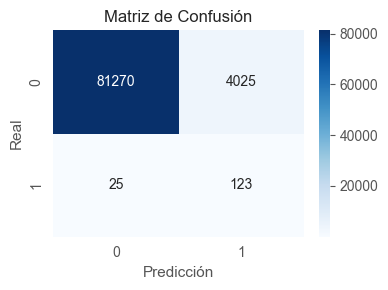

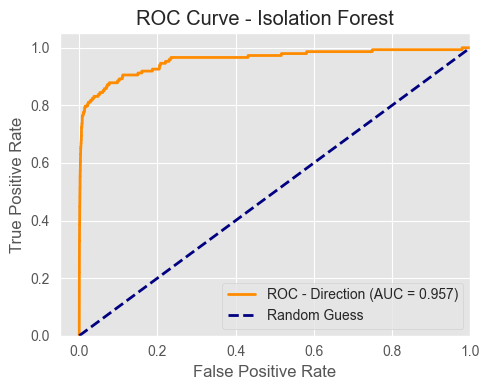

AUC - ROC para Isolation Forest es: 0.95717

ROC AUC Score: 0.8919


In [4]:
# Se declara una función para realizar la validación cruzada estratificada con Isolation Forest
def cross_validate_isolation_forest(X, y, params, n_splits=10):
    '''Realiza la validación cruzada estratificada con Isolation Forest.
    
    '''
    # Se inicializa el objeto StratifiedKFold
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        
        # Se crea un dataframe de entrenamiento con las variables predictoras correspondientes a transacciones legítimas
        X_train_normal = X_train_cv[y_train_cv == 0]
        
        # Se entrena el modelo con el conjunto de entrenamiento
        model = IsolationForest(**params, max_samples='auto', bootstrap=True, contamination='auto', random_state=42)
        model.fit(X_train_normal)
        
        # Se realizan las predicciones con el conjunto de validación
        y_pred = model.predict(X_val_cv)
        y_pred_binary = np.where(y_pred == -1, 1, 0)
        score = roc_auc_score(y_val_cv, y_pred_binary, average='micro')
        scores.append(score)
    
    return np.mean(scores)

# Se defienen los parámetros a evaluar en la función creada anteriormente.
param_grid = {
    'n_estimators': [50, 74, 75, 76, 100],
     'max_features': [0.1, 0.315, 0.320, 0.325, 0.5],
}

# Se realiza la calibración de hiperparámetros con la función creada anteriormente.
results = []
for params in itt.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    cv_score = cross_validate_isolation_forest(X_train_scaled, y_train, param_dict)
    results.append((param_dict, cv_score))

# Se ordenan los resultados por el score obtenido
results.sort(key=lambda x: x[1], reverse=True)

# Se muestran los resultados obtenidos para los mejores hipérparámetros.
best_params, best_score = results[0]
print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Se crea un dataframe con los resultados obtenidos
results_df = pd.DataFrame([(str(r[0]), r[1]) for r in results], columns=['params', 'cv_score'])
print("\nTop 5 models by cross-validation score:")
print(results_df.head())

# Se entrena el modelo con los mejores hiperparámetros encontrados
best_model = IsolationForest(**best_params, max_samples='auto', bootstrap=True, random_state=42)
best_model.fit(X_train_normal)  
y_pred = best_model.predict(X_test_scaled)
y_pred = np.where(y_pred == -1, 1, 0)

# Se evalúa el modelo con las métricas de desempeño de clasificación definidas anteriormente
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

matriz_confusion(y_test, y_pred)
metrica_roc_auc('Isolation Forest', y_test, best_model.decision_function(X_test_scaled))   

roc_auc = roc_auc_score(y_test, y_pred, average='micro')
print(f"\nROC AUC Score: {roc_auc:.4f}")

In [5]:
# Se crea un dataframe con los resultados obtenidos
test_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'amount': X_test['Amount']})

# Se realiza un análisis financiero de los resultados obtenidos
monto_fraude = df_model[df_model['Class'] == 1]['Amount'].sum()
monto_legitima = df_model[df_model['Class'] == 0]['Amount'].sum()
verdaderos_positivos= test_df[(test_df['actual'] == 1) & (test_df['predicted'] == 1)]['amount'].sum()
falsos_positivos = test_df[(test_df['actual'] == 0) & (test_df['predicted'] == 1)]['amount'].sum()
falsos_negativos = test_df[(test_df['actual'] == 1) & (test_df['predicted'] == 0)]['amount'].sum()

# Se muestran los resultados obtenidos del análisis financiero
print(f"Análisis Financiero de los Resultados:\n")
print(f"{'Category':<60}{'Amount ($)':<15}")
print(f"{'-' * 75}")
print(f"{'Monto de Transacciones Legitimas:':<60}${monto_legitima:>14,.2f}")
print(f"{'Monto de Transacciones Fraudulentas:':<60}${monto_fraude:>14,.2f}")
print(f"{'Verdaderos Positivos - TP (Detección de Fraude Correcta):':<60}${verdaderos_positivos:>14,.2f}")
print(f"{'Falsos Positivos - FP (Advertencia de Fraude Incorrecta):':<60}${falsos_positivos:>14,.2f}")
print(f"{'Falso Negativo - FN (Fraudes No Detectados):':<60}${falsos_negativos:>14,.2f}")

Análisis Financiero de los Resultados:

Category                                                    Amount ($)     
---------------------------------------------------------------------------
Monto de Transacciones Legitimas:                           $ 25,102,462.04
Monto de Transacciones Fraudulentas:                        $     60,127.97
Verdaderos Positivos - TP (Detección de Fraude Correcta):   $     14,828.48
Falsos Positivos - FP (Advertencia de Fraude Incorrecta):   $  2,190,967.50
Falso Negativo - FN (Fraudes No Detectados):                $      4,483.41


In [6]:
# Se declara una función para graficar las predicciones del modelo con t-SNE
def plot_tsne(X, y, y_pred, title):
    '''
    Grafica las predicciones del modelo con t-SNE.
    '''
    # Se aplica t-SNE a las variables independientes
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
    X_tsne = tsne.fit_transform(X)
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Se crea un dataframe con las variables transformadas
    df_tsne = pd.DataFrame({
        'x': X_tsne[:, 0],
        'y': X_tsne[:, 1],
        'true_label': y,
        'predicted_label': y_pred
    })
    
    # Se grafican los resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Gráfica del dataset original
    sns.scatterplot(data=df_tsne, x='x', y='y', hue='true_label', palette={0: 'blue', 1: 'red'}, ax=ax1)
    ax1.set_title(f'{title} - True Labels')
    ax1.legend(title='True Label', labels=['Normal', 'Fraud'])
    
    # Grafica de las predicciones del modelo
    sns.scatterplot(data=df_tsne, x='x', y='y', hue='predicted_label', palette={0: 'blue', 1: 'red'}, ax=ax2)
    ax2.set_title(f'{title} - Predicted Labels')
    ax2.legend(title='Predicted Label', labels=['Normal', 'Fraud'])
    
    plt.tight_layout()
    plt.show()

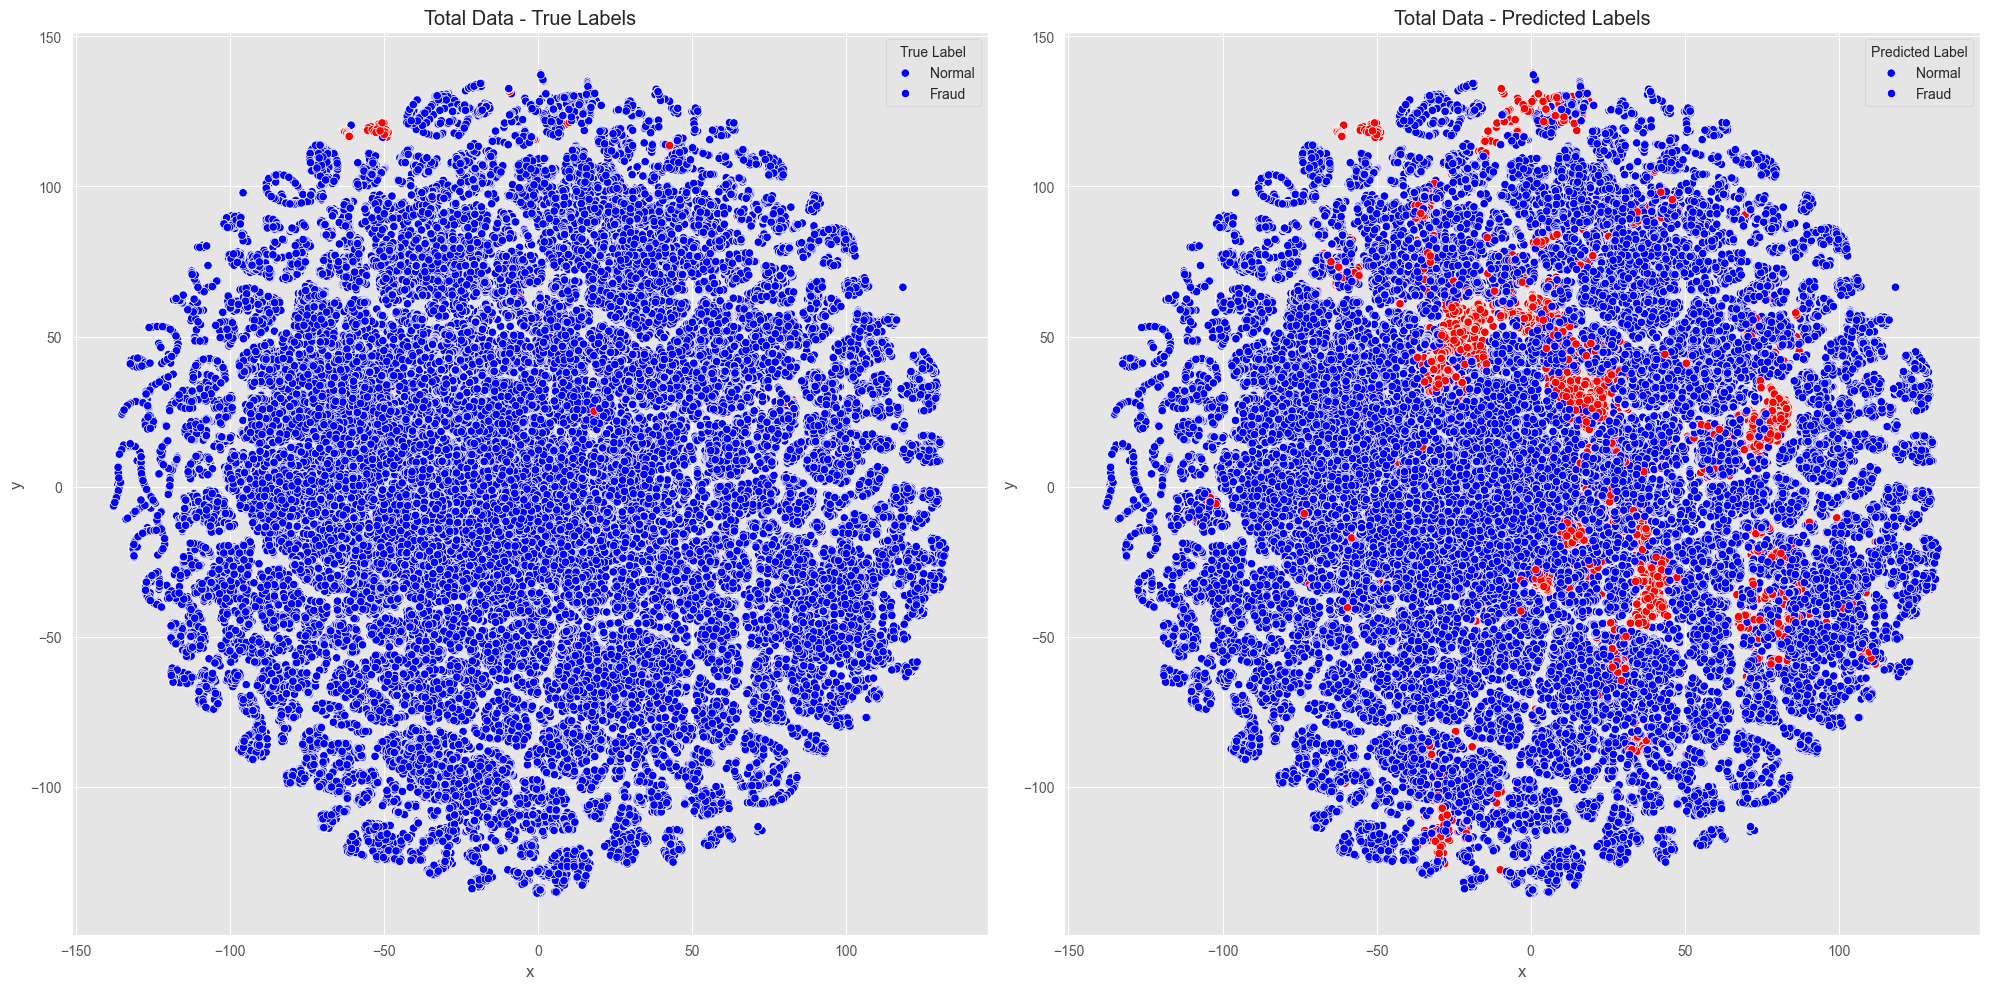

In [7]:
# Se grafican las predicciones del modelo aplicado a la totalidad del dataset con t-SNE
X_scaled = scaler.fit_transform(X)
plot_tsne(X_scaled, y, best_model.predict(X_scaled), "Total Data")

In [8]:
# Se declara una función para graficar la función de decisión del modelo con t-SNE
def plot_decision_function(X, y, y_pred, model, title):
    '''
    Grafica la función de decisión del modelo con t-SNE.
    '''
    # Se aplica t-SNE a las variables independientes
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-1) 
    X_tsne = tsne.fit_transform(X)
    
    # Se obtienen los scores de la función de decisión    
    scores = model.decision_function(X)
    
    # Se crea un dataframe con las variables transformadas
    df_tsne = pd.DataFrame({
        'x': X_tsne[:, 0],
        'y': X_tsne[:, 1],
        'true_label': y,
        'predicted_label': y_pred,
        'decision_score': scores
    })
    
    # Se grafican los resultados
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(df_tsne['x'], df_tsne['y'], c=df_tsne['decision_score'], 
                          cmap='rocket', alpha=0.7)
    plt.colorbar(scatter, label='Decision Score')
    plt.title(f'{title} - Decision Function')
    plt.tight_layout()
    plt.show()

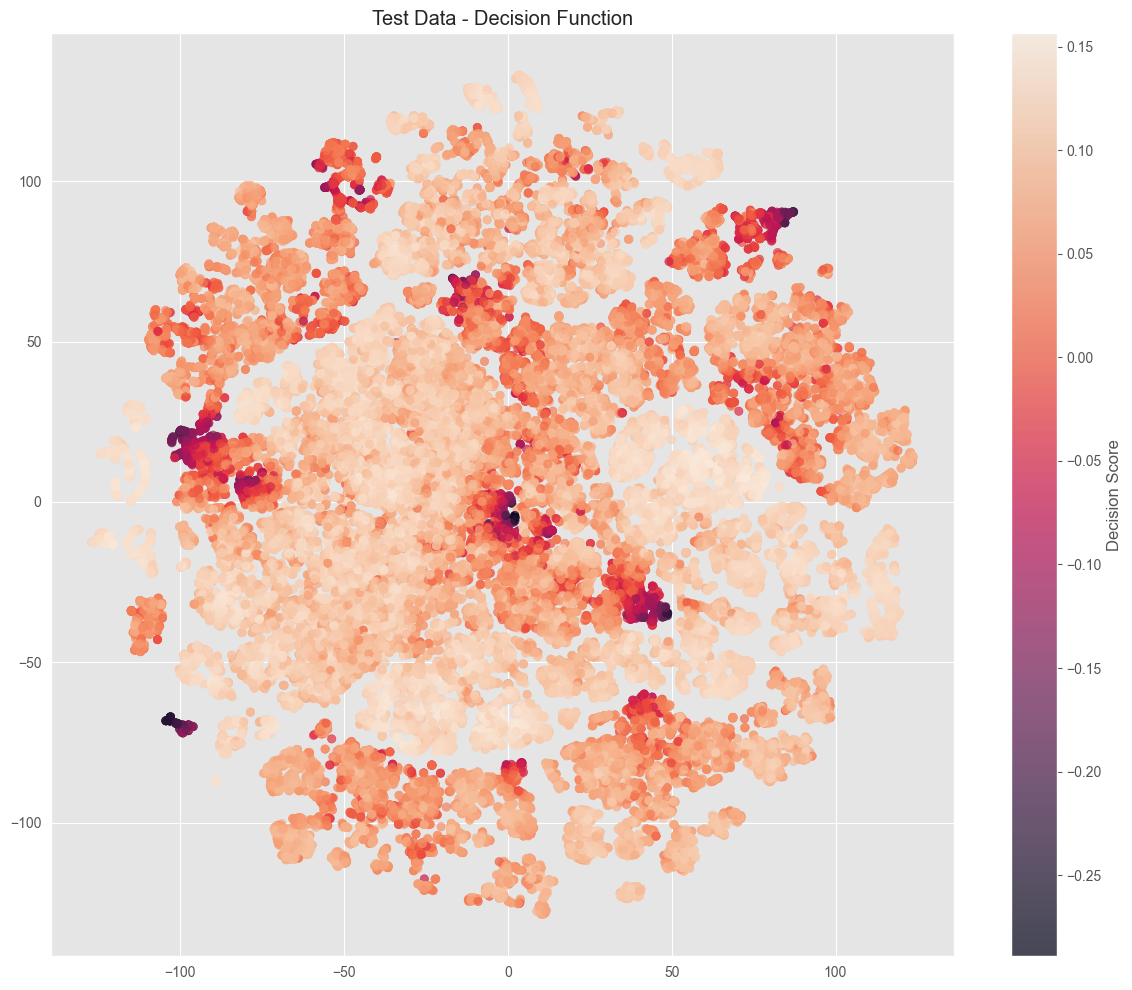

In [9]:
# Se grafica la función de decisión del modelo aplicado a la totalidad del dataset con t-SNE
plot_decision_function(X_test_scaled, y_test, y_pred, best_model, "Test Data")